In [16]:
import ace_lensing
import matplotlib.pyplot as plt
import numpy as np

# Predict a PDF

In [64]:
args1 = {
    "Om": 0.3,
    "h": 0.68,
    "w": -1.0,
    "s8": 0.73,
    "z": 1.0
}

args2 = {
    "Om": 0.3,
    "h": 0.68,
    "w": -1.0,
    "s8": 0.9,
    "z": 1.0
}

mu, pdf = ace_lensing.predict_pdf(**args1)
mu2, pdf2 = ace_lensing.predict_pdf(**args2)

Received input parameters: Om=0.3, h=0.68, w=-1.0, s8=0.73, z=1.0
Received input parameters: Om=0.3, h=0.68, w=-1.0, s8=0.9, z=1.0


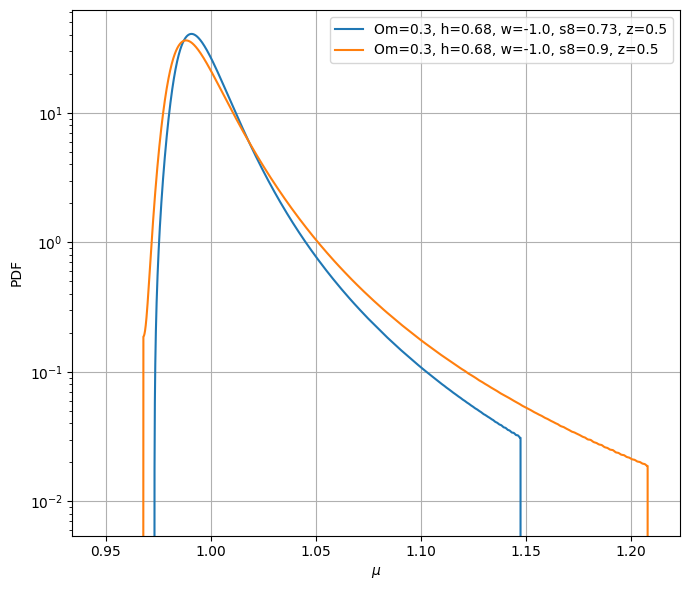

In [63]:
plt.figure(figsize=(7, 6))
plt.plot(mu, pdf, label=", ".join(f"{k}={v}" for k, v in args1.items()))
plt.plot(mu2, pdf2, label=", ".join(f"{k}={v}" for k, v in args2.items()))
plt.xlabel(r"$\mu$")
plt.ylabel("PDF")
plt.yscale('log')


plt.tight_layout()
plt.legend()
plt.grid()

# Predict a Sigma

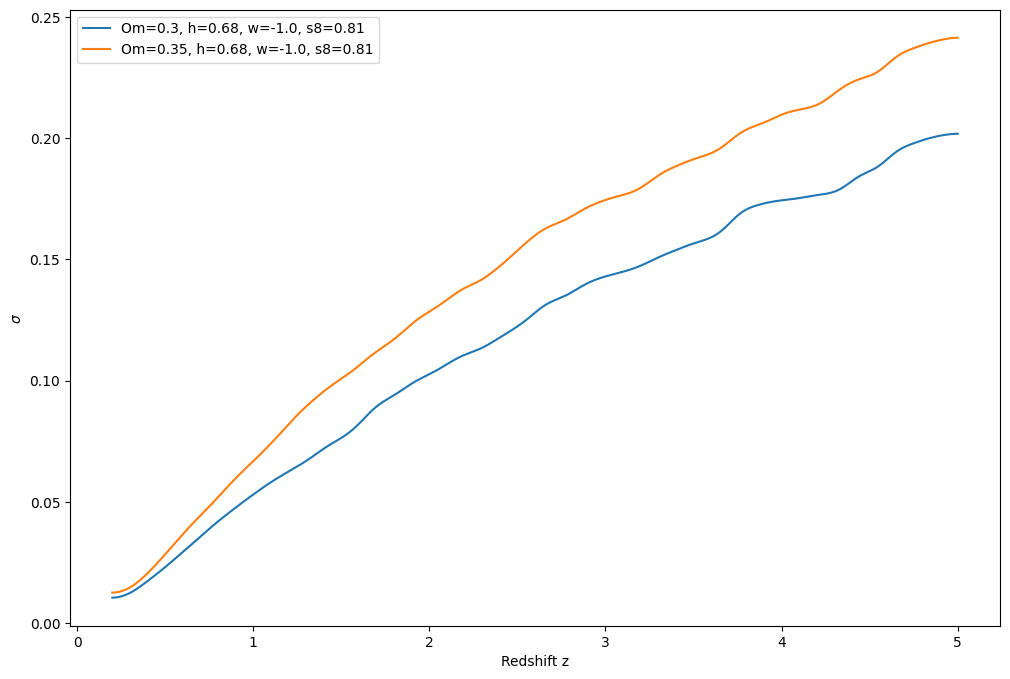

In [30]:
from scipy.ndimage import gaussian_filter1d

plt.figure(figsize=(12, 8))

redshifts = np.linspace(0.2, 5, 500)
parameter_names = ["Om",	"h",	"w",	"s8"]
params = [0.3, 0.68, -1.0, 0.81]
params2 = [0.35, 0.68, -1.0, 0.81]


sigma = np.array([])
for red in redshifts:
    cosmo=params
    cosmo = np.append(cosmo,red)
    sigma = np.append(sigma, ace_lensing.predict_sigma(*cosmo, verbose=False))
    sigma_smoothed = gaussian_filter1d(sigma, sigma=7)

sigma2 = np.array([])
for red in redshifts:
    cosmo=params2
    cosmo = np.append(cosmo,red)
    sigma2 = np.append(sigma2, ace_lensing.predict_sigma(*cosmo, verbose=False))
    sigma_smoothed2 = gaussian_filter1d(sigma2, sigma=7)

plt.plot(redshifts, sigma_smoothed, label=", ".join(f"{k}={v}" for k, v in zip(parameter_names, params)) )
plt.plot(redshifts, sigma_smoothed2, label=", ".join(f"{k}={v}" for k, v in zip(parameter_names, params2)) )
plt.xlabel("Redshift z")
plt.ylabel(r"$\sigma$")
plt.legend()
plt.show()

# Loading test set

In [26]:
df_test = ace_lensing.load_testing_data()

Received input parameters: Om=0.3576, h=0.743434, w=-0.8212, s8=0.8717, z=0.2753
Received input parameters: Om=0.2828, h=0.626263, w=-0.9606, s8=0.704, z=1.2711
Received input parameters: Om=0.2788, h=0.717172, w=-1.2939, s8=0.7828, z=4.3034


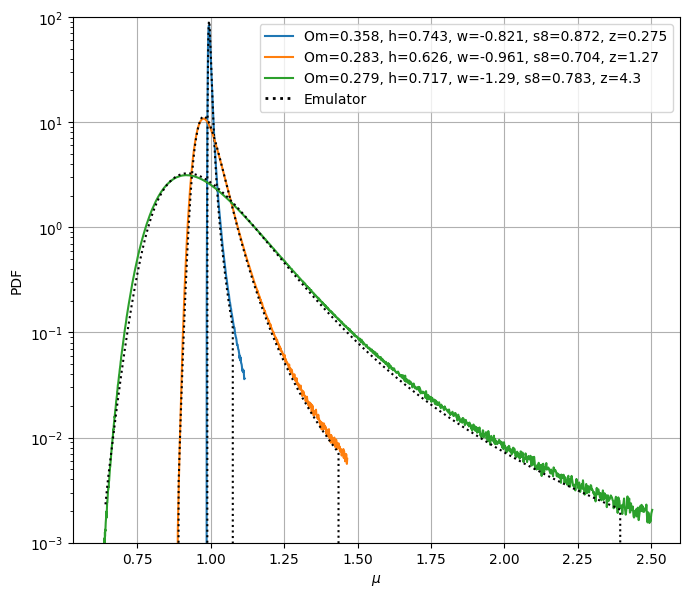

In [61]:
from matplotlib.lines import Line2D
samples = [1157, 1301, 1159]

plt.figure(figsize=(7, 6))
parameter_names = ["Om",	"h",	"w",	"s8", "z"]

for sample in samples:
    params = df_test.loc[sample, parameter_names].to_numpy()
    mu_test = df_test.loc[sample, "mu_vec"] * np.sqrt(df_test.loc[sample, "var"]) + df_test.loc[sample, "mean"]
    pdf_test = df_test.loc[sample, "pdf"] / np.sqrt(df_test.loc[sample, "var"])
    pdf_test = pdf_test / np.sum(pdf_test * np.diff(mu_test)[0])  

    mu_pred, pdf_pred = ace_lensing.predict_pdf(*params)

    label_params = ", ".join(f"{k}={v:.3g}" for k, v in zip(parameter_names, params))

    plt.plot(mu_test[:-1], pdf_test, label=f"{label_params}")
    plt.plot(mu_pred, pdf_pred, color="black", ls=":")

    

plt.xlabel(r"$\mu$")
plt.ylabel("PDF")
plt.yscale('log')

plt.tight_layout()

plt.grid()
plt.ylim(1e-3, 100)
style_labels = {Line2D([0], [0], color='black', lw=2, ls=':', label='Emulator')}
handles, labels = plt.gca().get_legend_handles_labels()
handles += style_labels
plt.legend(handles=handles)
plt.savefig(f'emulator.pdf', bbox_inches='tight', dpi=300)
plt.show()




# LOADING TRANING DATA

In [31]:
df = ace_lensing.load_training_data()
df

,mu_vec,pdf,poisson,Om,h,w,s8,z,mean,var,3th,4th,5th,6th,7th,8th,9th,10th
0,"[-2.0, -1.997999599919984, -1.995999199839968,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.3616,0.771717,-0.8091,0.7788,0.4950,0.999998,0.000785,0.000223,0.000265,0.000596,0.001743,0.005692,0.019635,0.069863,0.253490
1,"[-2.0, -1.997999599919984, -1.995999199839968,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.2848,0.757576,-1.0879,0.7000,0.4591,1.000000,0.000315,0.000038,0.000017,0.000014,0.000018,0.000028,0.000048,0.000085,0.000157
2,"[-2.0, -1.997999599919984, -1.995999199839968,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.3253,0.711111,-1.2152,0.7162,0.6787,0.999997,0.001182,0.000275,0.000336,0.000913,0.003371,0.013945,0.060702,0.271519,1.234997
3,"[-2.0, -1.997999599919984, -1.995999199839968,...","[-5.7564946e-05, -4.3518023e-05, -2.9471094e-0...","[3.4975942e-06, 3.5575456e-06, 3.6174972e-06, ...",0.2687,0.656566,-0.8394,0.7101,1.6926,0.999975,0.005575,0.002138,0.003566,0.009802,0.033505,0.126638,0.507094,2.109794,9.025269
4,"[-2.0, -1.997999599919984, -1.995999199839968,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0373825e-07, ...",0.3313,0.725253,-1.2758,0.8354,3.0348,0.999250,0.032235,0.025453,0.057869,0.176824,0.636917,2.493542,10.260631,43.630972,189.902576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152,"[-2.0, -1.997999599919984, -1.995999199839968,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.3535,0.775758,-1.0091,0.8798,0.4776,0.999996,0.000913,0.000313,0.000430,0.001068,0.003421,0.012349,0.047570,0.190605,0.783460
1153,"[-2.0, -1.997999599919984, -1.995999199839968,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.5529027e-06, 0.0, 0.0, 3.4600203e-07, 1.227...",0.3394,0.713131,-1.1848,0.8899,4.1402,0.998003,0.055176,0.054103,0.134715,0.426507,1.564247,6.197184,25.744797,110.410313,484.448863
1154,"[-2.0, -1.997999599919984, -1.995999199839968,...","[0.0003104302, 0.00032656052, 0.00034269085, 0...","[8.597913e-06, 8.795012e-06, 8.992111e-06, 9.1...",0.2162,0.646465,-1.0273,0.7283,1.8299,0.999985,0.005149,0.001644,0.002543,0.006866,0.023738,0.091624,0.375712,1.600030,6.990965
1155,"[-2.0, -1.997999599919984, -1.995999199839968,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.3091,0.777778,-1.1303,0.8778,0.6827,0.999991,0.001807,0.000735,0.001171,0.003155,0.010541,0.039013,0.153099,0.624260,2.615483


## Findinf redshift close to 2 in the training data

In [37]:
matching_rows = df[df['z'].round(1) == 2]
matching_rows

,mu_vec,pdf,poisson,Om,h,w,s8,z,mean,var,3th,4th,5th,6th,7th,8th,9th,10th
44,"[-2.0, -1.997999599919984, -1.995999199839968,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.3051,0.751515,-1.2394,0.8576,1.9958,0.999715,0.016522,0.011373,0.024243,0.073065,0.261191,1.017715,4.174675,17.717892,77.041075
133,"[-2.0, -1.997999599919984, -1.995999199839968,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0977205e-06, 1.097235e-06, 1.0967494e-06, 1...",0.2505,0.672727,-1.2333,0.8556,2.0240,0.999859,0.012058,0.006730,0.013216,0.038688,0.137181,0.533921,2.193247,9.329361,40.661993
149,"[-2.0, -1.997999599919984, -1.995999199839968,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.6553237e-06, 2.7940591e-06, 2.9327944e-06, ...",0.2808,0.721212,-0.7970,0.7141,1.9839,0.999937,0.008382,0.003771,0.006671,0.018560,0.063937,0.244057,0.988486,4.160128,17.982632
167,"[-2.0, -1.997999599919984, -1.995999199839968,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.8800404e-06, 1.8947252e-06, 1.90941e-06, 1....",0.3232,0.604040,-0.8818,0.7465,2.0251,0.999888,0.011254,0.005887,0.011190,0.032128,0.112757,0.436851,1.793304,7.644046,33.450381
255,"[-2.0, -1.997999599919984, -1.995999199839968,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.978917e-06, 1.6829957e-06, 1.3870745e-06, 1...",0.3131,0.749495,-1.2697,0.7667,2.0094,0.999868,0.013557,0.007511,0.014706,0.042760,0.150655,0.581929,2.370005,9.989202,43.131293
311,"[-2.0, -1.997999599919984, -1.995999199839968,...","[0.00013483861, 0.00014059301, 0.0001463474, 0...","[6.7379065e-06, 6.874193e-06, 7.0104797e-06, 7...",0.2848,0.757576,-1.0879,0.7000,2.0125,0.999951,0.009312,0.003852,0.006668,0.018481,0.063855,0.243796,0.984357,4.120711,17.698550
462,"[-2.0, -1.997999599919984, -1.995999199839968,...","[0.00044408257, 0.0004680031, 0.00049192365, 0...","[1.1137741e-05, 1.1409652e-05, 1.1681563e-05, ...",0.2242,0.644444,-1.1242,0.7364,1.9911,0.999981,0.006798,0.002317,0.003691,0.009891,0.033701,0.127969,0.516199,2.163818,9.315675
516,"[-2.0, -1.997999599919984, -1.995999199839968,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.7936057e-06, 2.763401e-06, 2.7331962e-06, 2...",0.3152,0.674747,-1.2818,0.7626,2.0111,0.999881,0.012810,0.006643,0.012552,0.035785,0.124939,0.480711,1.956188,8.255865,35.750112
524,"[-2.0, -1.997999599919984, -1.995999199839968,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0026778e-06, 9.4304585e-07, 8.83414e-07, 8....",0.3515,0.781818,-1.0455,0.7263,1.9968,0.999840,0.013906,0.007940,0.015642,0.045779,0.162993,0.638499,2.642854,11.333263,49.807315
722,"[-2.0, -1.997999599919984, -1.995999199839968,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 2.4304583e-07, 5.995585e-...",0.3859,0.759596,-1.1545,0.8212,2.0433,0.999498,0.021748,0.017071,0.038300,0.117944,0.426917,1.678857,6.938034,29.626751,129.475012
